# lesson 3

本节主要是学习如何使用Shapely, Geopandas和其他相关库管理和分析空间数据:

- Geocoding / Geocoding in Geopandas
- Conduct a Point in Polygon queries
- How to boost spatial queries using spatial index
- Make spatial and table joins between layers
- Nearest neighbour analysis

## 学习目标

- 执行geocoding，转换地址为坐标
- 执行point-in-polygon查询
- 从WFS服务和KML文件中读取数据
- 空间连接
- 执行最近邻分析，即找到最近的点

## Geocoding

geocoding，比如地址和Points之间的转换，是非常常见的GIS任务。又非常幸运的是，在python中有一些很nice的库使geocoding很容易。比如[geopy](http://geopy.readthedocs.io/en/1.11.0/)，该库通过使用第三方的geocoders和其他数据源可以很轻松的定位全球地址，城市，国家和地标的坐标。这些第三方geocoders包括：

- [ESRI ArcGIS](https://developers.arcgis.com/rest/geocode/api-reference/overview-world-geocoding-service.htm)
- [Baidu Maps](http://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding)
- [Bing](https://msdn.microsoft.com/en-us/library/ff701715.aspx)
- [GeocodeFarm](https://www.geocode.farm/geocoding/free-api-documentation/)
- [GeoNames](http://www.geonames.org/export/geonames-search.html)
- [Google Geocoding API (V3)](https://developers.google.com/maps/documentation/geocoding/)
- [HERE](https://developer.here.com/documentation/geocoder/)
- [IGN France](https://geoservices.ign.fr/documentation/geoservices/index.html)
- [Mapquest](https://developer.mapquest.com/documentation/open/)
- [OpenCage](https://opencagedata.com/api)
- [OpenMapQuest](http://developer.mapquest.com/web/products/open/geocoding-service)
- [Open Street Map Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim)
- [What3words](https://developer.what3words.com/public-api/docsv2#overview)
- [Yandex](https://tech.yandex.com/maps/doc/geocoder/desc/concepts/input_params-docpage/)

这些源暂时不一一记录了。总之有很多geocoders可选，他们之间有所不同。不过为了使用服务，需要从服务商那里申请API访问keys，比如google的Geocoding API，需要在谷歌云的[API控制台](https://code.google.com/apis/console)上创建项目并启动一个来自[库](https://console.developers.google.com/apis/library)的API，对google的话，在库中搜索geocoder，会出来Geocoding API，启用它即可。这里有一个如何使用Google API Console的[说明](https://developers.googleblog.com/2016/03/introducing-google-api-console.html)。使用geocoder之前需要获取google的geocoding key api，这部分可以参考谷歌文档[Get an API Key](https://developers.google.com/maps/documentation/geocoding/get-api-key)。按照文档步骤一步步即可。

不过这类服务有rate limiting，短时间内的请求太多会报错。不过可以查询[geopy文档](https://geopy.readthedocs.io/en/stable/#usage-with-pandas)看看如何处理rate limiting。

更多geocoders信息可参考:[Geocoder: Simple, Consistent](https://geocoder.readthedocs.io/)

这里选择使用Nominatim geocoder来定位较小数目的地址。该服务允许每秒1次的请求，可参考[文档](https://operations.osmfoundation.org/policies/nominatim/)

因为Nominatim是一基于OpenStreetMap data的，因此当访问的数量不大时，它不需要API key，这点非常棒！

### Geocoding in Geopandas

geopands整合了geopy的函数。geopandas的geocode()函数可以geocode一系列的地址，并返回一个包含geometry列的GeoDataframe，列中都是地址对应的点。

数据在这里下载：https://github.com/Automating-GIS-processes/site/tree/master/source/notebooks/L3/data

In [15]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Filepath
fp = r"data/addresses.txt"

# Read the data
data = pd.read_csv(fp, sep=';')
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [16]:
# Import the geocoding tool
from geopandas.tools import geocode

# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_xx', timeout=4)

In [17]:
geo.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93169 60.16902),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp..."
2,POINT (24.94168 60.16996),"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel..."
3,POINT (24.97193 60.19700),"Hermannin rantatie, Kyläsaari, Hermanni, Helsi..."
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län..."


### Table join

Table join也是GIS分析中很常用的，也就是基于相同的key属性，把不同表的数据join起来，这在geopandas中可以用merge函数实现。

In [18]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93169 60.16902),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94168 60.16996),"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97193 60.19700),"Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [19]:
type(join)

geopandas.geodataframe.GeoDataFrame

In [20]:
# Output file path
outfp = r"data/addresses.shp"

# Save to Shapefile
join.to_file(outfp)

## Point in Polygon & Intersect

判断一个点在一个区域内还是区域外，或者看看一条线有没有和另一条线或多边形相交，都是很常见的地理空间运算。这些都是基于位置来选择数据的操作。这些空间查询是很多空间分析典型的第一步。

### 如何判断一个点在不在polygon内

这个问题有一个经典算法[Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm)。又很幸运的，the Point in Polygon (PIP) query问题不需要手写该算法，使用 [Shapely’s binary predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)可以很快的分析地理对象的空间关系。

Shapely中有两种基本方式处理PIP问题：

1. 使用.within()函数检查一个点是否在polygon内；
2. 使用.contains()检查一个polygon是否包含一个point。

同样这两个函数还可以检查LineString和Polygon是否在一个Polygon内。

In [21]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

# Let's check what we have
print(p1)
print(p2)
print(poly)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


In [22]:
# Check if p1 is within the polygon using the within function
p1.within(poly)

True

In [23]:
# Check if p2 is within the polygon
p2.within(poly)

False

In [24]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

POINT (24.952242 60.1696017)
POINT (24.95224242849236 60.16960179038188)


In [25]:
# Does polygon contain p1?
poly.contains(p1)

True

In [26]:
# Does polygon contain p2?
poly.contains(p2)

False

如果有许多点，只有一个polygon，然后找出哪些点在polygon，那就循环点，使用within来判断；如果有很多polygons，有一个点，那就用contains函数。

### Intersect

另一个常用的地理空间运算是看一个geometry是否和另一个相交或接触。Shapely中有两个运算可以检验这种空间关系：

- intersect()：两个geometry，一个边界或内部以任意方式和另一个的边界或内部相交；
- touches()：两个对象，如果两个对象有至少一个共同的点，并且内部不相交，那么就是touch的。

接着直接上例子：

In [1]:
from shapely.geometry import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])
line_a.intersects(line_b)

True

In [2]:
line_a.touches(line_b)

True

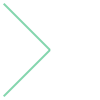

In [3]:
# Create a MultiLineString from line_a and line_b
multi_line = MultiLineString([line_a, line_b])
multi_line

In [4]:
# Does the line touch with itself?
line_a.touches(line_a)

False

In [5]:
# Does the line intersect with itself?
line_a.intersects(line_a)

True

### Point in Polygon using Geopandas

接下来一个实例是判断哪些地点在一个区域内。数据可以在[这里](https://github.com/Automating-GIS-processes/site/tree/master/source/notebooks/L3/data)下载，这里已经下载好了，不必再下载了。

In [6]:
import geopandas as gpd

fp = "data/addresses.shp"
data = gpd.read_file(fp)

data.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94168 60.16996)
3,"Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97193 60.19700)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


在geopandas中读取KML文件和shapefile文件读取比较像。不过首先，要使能KML驱动，它不是默认可用的（因为KML文件可能包含不支持的数据结构，比如嵌套的文件夹等，因此读取KML文件要小心）。目前支持的驱动可见：[fiona.supported_drivers](https://github.com/Toblerity/Fiona/blob/master/fiona/drvsupport.py)，这些都被整合进geopandas了。

In [7]:
import geopandas as gpd
# 检查支持哪些格式
gpd.io.file.fiona.drvsupport.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

通过传递'rw'参数给fiona支持的驱动的白名单来使驱动有读写功能。

In [8]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

再看看支持的驱动情况：

In [9]:
gpd.io.file.fiona.drvsupport.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'KML': 'rw'}

可以看到KML已经是可读写的了。现在可以读取KML文件了。

In [10]:
# Filepath to KML file
fp = "data/PKS_suuralue.kml"
polys = gpd.read_file(fp, driver='KML')
#Check the data
print("Number of rows:",len(polys))
polys.head(11)

Number of rows: 23


,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."
5,Kauniainen,,"POLYGON Z ((24.69075 60.21958 0.00000, 24.6924..."
6,Suur-Leppävaara,,"POLYGON Z ((24.79747 60.20827 0.00000, 24.7954..."
7,Suur-Tapiola,,"POLYGON Z ((24.84436 60.16598 0.00000, 24.8443..."
8,Myyrmäki,,"POLYGON Z ((24.82459 60.29025 0.00000, 24.8243..."
9,Kivistö,,"POLYGON Z ((24.94309 60.33845 0.00000, 24.9421..."


可以看到数据已经读出，例子中有23个地区，都是polygon。

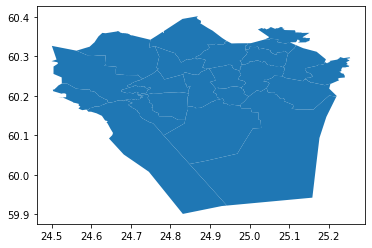

In [11]:
%matplotlib inline
polys.plot()

这里作为例子的感兴趣的地区是Eteläinen (‘Southern’ in English).

选出该区域来运算。

In [12]:
# Select data
southern = polys.loc[polys['Name']=='Eteläinen']
# Reset index for the selection
southern.reset_index(drop=True, inplace=True)
# Check the selction
southern.head()

,Name,Description,geometry
0,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


接下来，首先画出这个感兴趣的区域，然后再把地点都标到地图上。

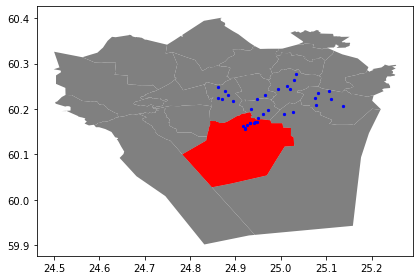

In [13]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
data.plot(ax=ax, color='blue', markersize=5)

plt.tight_layout()

可以看到有一些点是在红色区域内的。接着就执行那个PIP操作。首先，检查下有没有使shapely.speedups可用。该module可以使空间查询执行更快（从shapely 1.6.0开始，加速是默认的）。

In [14]:
#import shapely.speedups
from shapely import speedups
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

现在来检查下哪些点在southern polygon中。check if the Points are within the geometry of the southern GeoDataFrame.

In [15]:
pip_mask = data.within(southern.at[0, 'geometry'])
print(pip_mask)

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool


如上结果所示，得到很多boolean值。为True的就是point在polygon中的，false的就是不在的。现在可以用mask来选择在polygon中的点了。通过pandas的索引，可以很容易实现。

In [16]:
pip_data = data.loc[pip_mask]
pip_data

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94168 60.16996)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)
10,"The Pullman Bar, 1, Rautatientori, Keskusta, K...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.94229 60.17114)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93312 60.16909)
31,"Ruoholahdenkatu, Hietalahti, Kamppi, Eteläinen...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.92520 60.16489)
32,"3, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92121 60.15878)
33,"Oluthuone Kaisla, 4, Vilhonkatu, Keskusta, Klu...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94709 60.17191)


最后可视化结果确认下PIP查询执行的效果。

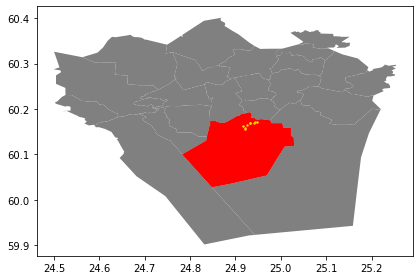

In [17]:
# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
pip_data.plot(ax=ax, color='gold', markersize=2)

plt.tight_layout()

至此，就把包含在polygon中的点找出来了。